# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
import subprocess
from IPython.display import display, Markdown, HTML

suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [3]:
from data_processing import load_data

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 22 Feb 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":"community_ageband",
        "70-79":"community_ageband", 
        "care home":"community_ageband", 
        "shielding (aged 16-69)":"shielded", 
        "65-69": "community_ageband",              
        "under 65s, not in other eligible groups shown":"other" 
        # NB the "other" group must contain phrase "not in other eligible groups"
        }

groups = population_subgroups.keys()

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {"other":    ["sex","ageband", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories",
                              "bmi","chronic_cardiac_disease", "current_copd", "dmards","ssri"],
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15","sex", "ageband", "ethnicity_6_groups", "imd_categories"],
                 "65-69":    ["sex","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "chronic_cardiac_disease", "current_copd", "dmards", "dementia",
                              "psychosis_schiz_bipolar","intel_dis_incl_downs_syndrome","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                 "DEFAULT":   ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                              "psychosis_schiz_bipolar","intel_dis_incl_downs_syndrome","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

### Cumulative vaccination figures - overall

In [12]:
from report_results import make_vaccine_graphs

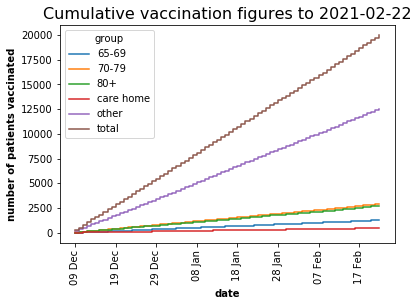

In [13]:
make_vaccine_graphs(df, latest_date=latest_date, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [14]:
from report_results import summarise_data_by_group

In [15]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [16]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [17]:
summ_stat_results = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, savepath=savepath, suffix=suffix)

In [18]:
# display the results of the summary stats in notebook
for x in summ_stat_results.keys():
    display(Markdown(f"{x}: {summ_stat_results[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

### As at 22 Feb 2021: 

**Total** population vaccinated in TPP: 19,999

**80+** population vaccinated: 2,744 (40.4% of 6,790)

**70-79** population vaccinated: 2,933 (40.1% of 7,322)

**care home** population vaccinated: 476 (41.9% of 1,141)

**shielding (aged 16-69)** population vaccinated: 161 (39.0% of 420)

**65-69** population vaccinated: 1,288 (41.3% of 3,122)

**under 65s, not in other eligible groups shown** population vaccinated: 12,390

#### Vaccine types and second doses: 

Second doses (% of all vaccinated): 4,998 (25.0%)

Oxford-AZ vaccines (% of all first doses): 7 (0.0%)

*
 figures rounded to nearest 7

# Detailed summary of coverage among population groups as at latest date

In [19]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)

## 

## COVID vaccination rollout among **80+** population up to 22 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                    2742   
sex                           F                                          1379   
                              M                                          1365   
ageband_5yr                   0                                           168   
                              0-15                                        147   
                              16-29                                       175   
                              30-34                                       147   
                              35-39                                       175   
                              40-44                                       161   
                              45-49                                       161   
                              50-54                                       175   
                              55-59                                       168   
                              60-64                                       182   
                              65-69                                       182   
                              70-74                                       189   
                              75-79                                       182   
                              80-84                                       189   
                              85-89                                       161   
                              90+                                         182   
ethnicity_6_groups            Black                                       364   
                              Mixed                                       392   
                              Other                                       420   
                              South Asian                                 427   
                              Unknown                                     707   
                              White                                       427   
ethnicity_16_groups            African                                    126   
                               Bangladeshi or British Bangladeshi         126   
                               Caribbean                                  126   
                               Chinese                                    126   
                               Other                                      119   
                               Other Asian                                119   
                              British or Mixed British                    140   
                              Indian or British Indian                    147   
                              Irish                                       140   
                              Other Black                                 126   
                              Other White                                 126   
                              Other mixed                                 140   
                              Pakistani or British Pakistani              119   
                              Unknown                                     679   
                              White + Asian                               126   
                              White + Black African                       133   
                              White + Black Caribbean                     119   
imd_categories                1 Most deprived                             518   
                              2                                           560   
                              3                                           518   
                              4                                           525   
                              5 Least deprived                            490   
                              Unknown                                     140   
bmi              

## 

## COVID vaccination rollout among **70-79** population up to 22 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                    2935   
sex                           F                                          1491   
                              M                                          1442   
ageband_5yr                   0                                           182   
                              0-15                                        203   
                              16-29                                       175   
                              30-34                                       189   
                              35-39                                       196   
                              40-44                                       168   
                              45-49                                       189   
                              50-54                                       189   
                              55-59                                       161   
                              60-64                                       161   
                              65-69                                       175   
                              70-74                                       203   
                              75-79                                       182   
                              80-84                                       196   
                              85-89                                       168   
                              90+                                         182   
ethnicity_6_groups            Black                                       448   
                              Mixed                                       455   
                              Other                                       427   
                              South Asian                                 434   
                              Unknown                                     714   
                              White                                       448   
ethnicity_16_groups            African                                    154   
                               Bangladeshi or British Bangladeshi         140   
                               Caribbean                                  140   
                               Chinese                                    119   
                               Other                                      126   
                               Other Asian                                133   
                              British or Mixed British                    133   
                              Indian or British Indian                    140   
                              Irish                                       140   
                              Other Black                                 147   
                              Other White                                 154   
                              Other mixed                                 147   
                              Pakistani or British Pakistani              140   
                              Unknown                                     700   
                              White + Asian                               133   
                              White + Black African                       147   
                              White + Black Caribbean                     147   
imd_categories                1 Most deprived                             532   
                              2                                           560   
                              3                                           560   
                              4                                           553   
                              5 Least deprived                            595   
                              Unknown                                     140   
bmi              

## 

## COVID vaccination rollout among **care home** population up to 22 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             478     41.9   1141   
sex                F                   245     41.2    595   
                   M                   231     42.3    546   
ageband_5yr        0                    35     41.7     84   
                   0-15                 35     45.5     77   
                   16-29                28     40.0     70   
                   30-34                35     50.0     70   
                   35-39                21     33.3     63   
                   40-44                21     30.0     70   
                   45-49                28     40.0     70   
                   50-54                35     50.0     70   
                   55-59                35     50.0     70   
                   60-64                21     37.5     56   
                   65-69                35     41.7     84   
                   70-74                42     50.0     84   
                   75-79                28     40.0     70   
                   80-84                21     33.3     63   
                   85-89                28     40.0     70   
                   90+                  28     40.0     70   
ethnicity_6_groups Black                70     41.7    168   
                   Mixed                84     44.4    189   
                   Other                70     43.5    161   
                   South Asian          70     43.5    161   
                   Unknown             119     39.5    301   
                   White                63     39.1    161   
dementia           no                  476     42.0   1134   
                   yes                   0      0.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 38.1   
sex                F                                       37.6   
                   M                                       38.5   
ageband_5yr        0                                       41.7   
                   0-15                                    45.5   
                   16-29                                     40   
                   30-34                                     40   
                   35-39                                   33.3   
                   40-44                                     30   
                   45-49                                     40   
                   50-54                                     50   
                   55-59                                     40   
                   60-64                                   37.5   
                   65-69                                   41.7   
                   70-74                                     50   
                   75-79                                     30   
                   80-84                                   33.3   
                   85-89                                     40   
                   90+                                       40   
ethnicity_6_groups Black                                   37.5   
                   Mixed                                   40.7   
                   Other                                   43.5   
                   South Asian                             39.1   
                   Unknown                                 34.9   
                   White                                   39.1   
dementia           no                                      38.3   
                   yes                                        0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               3.8   
sex                F                                     3.6   
                   M             

## 

## COVID vaccination rollout among **shielding (aged 16-69)** population up to 22 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  164     39.0    420   
newly_shielded_since_feb_15 no                       161     38.3    420   
                            yes                        0      NaN      0   
sex                         F                         91     43.3    210   
                            M                         70     33.3    210   
ageband                     16-29                     21     33.3     63   
                            30-39                     21     42.9     49   
                            40-49                     21     37.5     56   
                            50-59                     14     28.6     49   
                            60-69                     21     37.5     56   
                            70-79                     42     40.0    105   
                            80+                       21     42.9     49   
ethnicity_6_groups          Black                     28     36.4     77   
                            Mixed                     14     25.0     56   
                            Other                     21     33.3     63   
                            South Asian               21     37.5     56   
                            Unknown                   49     43.8    112   
                            White                     28     50.0     56   
imd_categories              1 Most deprived           28     36.4     77   
                            2                         28     33.3     84   
                            3                         35     41.7     84   
                            4                         35     45.5     77   
                            5 Least deprived          35     45.5     77   
                            Unknown                   14     66.7     21   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      35.2   
newly_shielded_since_feb_15 no                                             35   
                            yes                                           NaN   
sex                         F                                              40   
                            M                                              30   
ageband                     16-29                                        33.3   
                            30-39                                        42.9   
                            40-49                                        37.5   
                            50-59                                        28.6   
                            60-69                                        37.5   
                            70-79                                          40   
                            80+                                          42.9   
ethnicity_6_groups          Black                                        27.3   
                            Mixed                                          25   
                            Other                                        33.3   
                            South Asian                                  37.5   
                            Unknown                                      37.5   
                            White                                          50   
imd_categories              1 Most deprived                              36.4   
                            2                                            33.3   
                            3                                            33.3   
                            4                                            36.4   
                            5 Least deprived                             36.4   
                            Unknown         

## 

## COVID vaccination rollout among **65-69** population up to 22 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                    1288   
sex                           F                                           644   
                              M                                           644   
ethnicity_6_groups            Black                                       182   
                              Mixed                                       189   
                              Other                                       189   
                              South Asian                                 196   
                              Unknown                                     315   
                              White                                       217   
ethnicity_16_groups            African                                     63   
                               Bangladeshi or British Bangladeshi          63   
                               Caribbean                                   63   
                               Chinese                                     63   
                               Other                                       63   
                               Other Asian                                 56   
                              British or Mixed British                     63   
                              Indian or British Indian                     56   
                              Irish                                        63   
                              Other Black                                  56   
                              Other White                                  70   
                              Other mixed                                  63   
                              Pakistani or British Pakistani               56   
                              Unknown                                     315   
                              White + Asian                                56   
                              White + Black African                        56   
                              White + Black Caribbean                      63   
imd_categories                1 Most deprived                             280   
                              2                                           217   
                              3                                           245   
                              4                                           231   
                              5 Least deprived                            259   
                              Unknown                                      56   
bmi                           30+                                         378   
                              under 30                                    910   
chronic_cardiac_disease       no                                         1274   
                              yes                                          14   
current_copd                  no                                         1281   
                              yes                                           7   
dmards                        no                                         1274   
                              yes                                          14   
dementia                      no                                         1274   
                              yes                                          14   
psychosis_schiz_bipolar       no                                         1281   
                              yes                                           7   
intel_dis_incl_downs_syndrome no                                         1274   
                              yes                                          14   
ssri                          no                                         1274   
                              yes                                          14   
chemo_or_radio   

## 

## COVID vaccination rollout among **under 65s, not in other eligible groups shown** population up to 22 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                   12393   
sex                     F                                          6265   
                        M                                          6125   
ageband                 16-29                                      1645   
                        30-39                                      1673   
                        40-49                                      1645   
                        50-59                                      1631   
                        60-69                                      1631   
                        70-79                                      2807   
                        80+                                        1365   
ethnicity_6_groups      Black                                      1841   
                        Mixed                                      1862   
                        Other                                      1897   
                        South Asian                                1869   
                        Unknown                                    3031   
                        White                                      1897   
ethnicity_16_groups      African                                    595   
                         Bangladeshi or British Bangladeshi         616   
                         Caribbean                                  574   
                         Chinese                                    553   
                         Other                                      609   
                         Other Asian                                595   
                        British or Mixed British                    602   
                        Indian or British Indian                    525   
                        Irish                                       574   
                        Other Black                                 574   
                        Other White                                 581   
                        Other mixed                                 595   
                        Pakistani or British Pakistani              602   
                        Unknown                                    3136   
                        White + Asian                               525   
                        White + Black African                       567   
                        White + Black Caribbean                     553   
imd_categories          1 Most deprived                            2422   
                        2                                          2394   
                        3                                          2415   
                        4                                          2254   
                        5 Least deprived                           2324   
                        Unknown                                     581   
bmi                     30+                                        3689   
                        under 30                                   8701   
chronic_cardiac_disease no                                        12257   
                        yes                                         133   
current_copd            no                                        12278   
                        yes                                         112   
dmards                  no                                        12271   
                        yes                                         126   
ssri                    no                                        12271   
                        yes                                         126   

                                                            vaccinated 7d previous  \
category                group                                                        
overall                 overall                                

# Demographics time trend charts

In [20]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 22 Feb 2021

### COVID vaccinations among **80+** population by **sex**

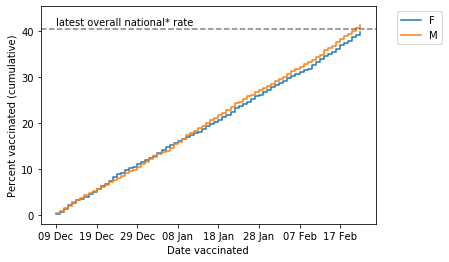

### COVID vaccinations among **80+** population by **ethnicity 6 groups**

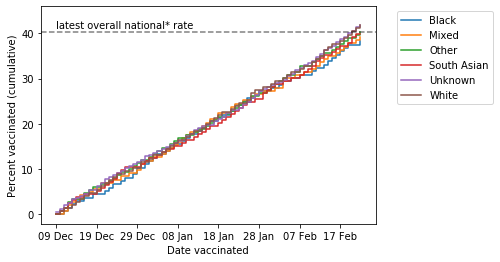

### COVID vaccinations among **80+** population by **imd categories**

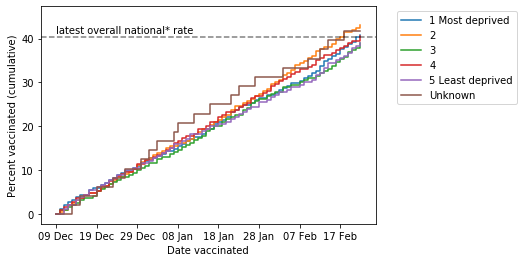

### COVID vaccinations among **80+** population by **bmi**

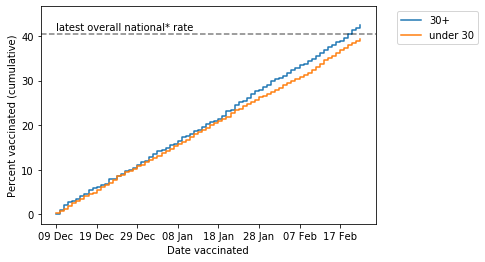

### COVID vaccinations among **80+** population by **chronic cardiac disease**

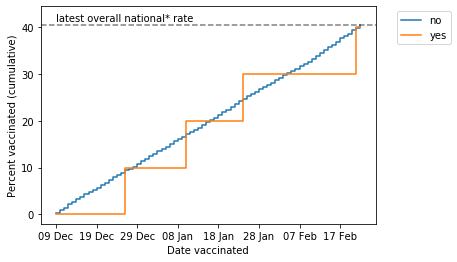

### COVID vaccinations among **80+** population by **current copd**

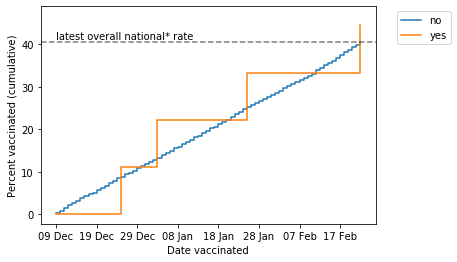

### COVID vaccinations among **80+** population by **dialysis**

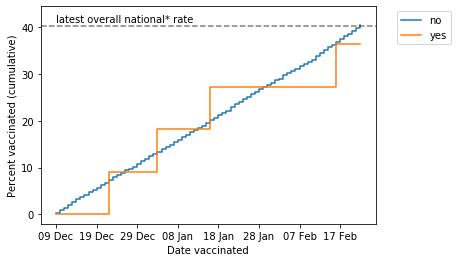

### COVID vaccinations among **80+** population by **dmards**

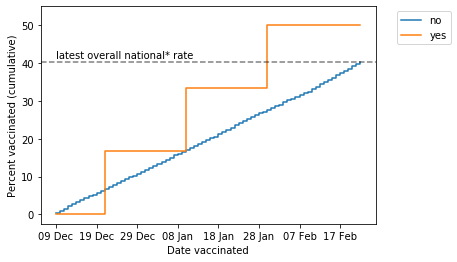

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

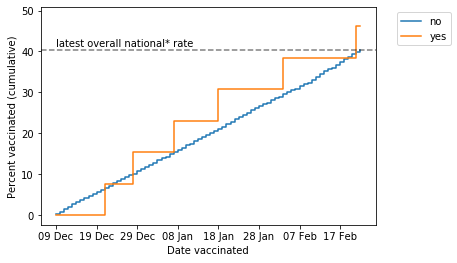

### COVID vaccinations among **80+** population by **intel dis incl downs syndrome**

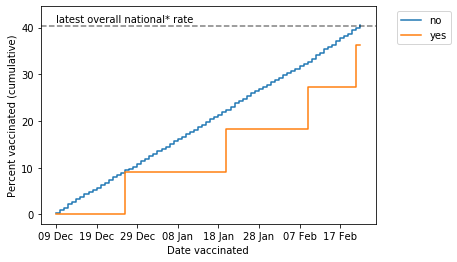

### COVID vaccinations among **80+** population by **dementia**

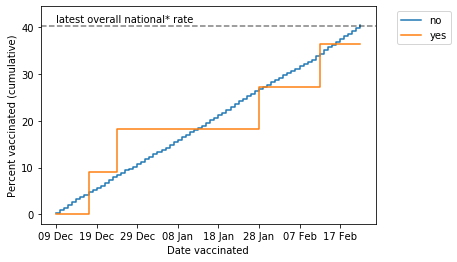

### COVID vaccinations among **80+** population by **ssri**

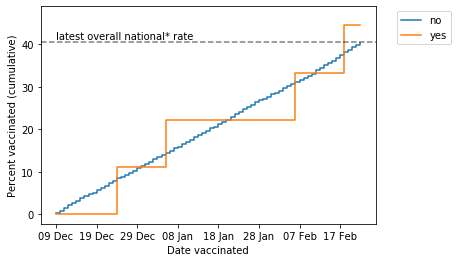

### COVID vaccinations among **80+** population by **chemo or radio**

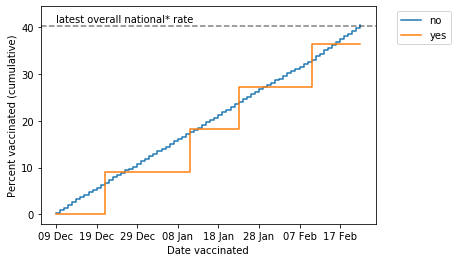

### COVID vaccinations among **80+** population by **lung cancer**

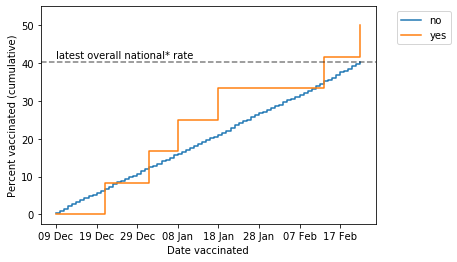

### COVID vaccinations among **80+** population by **cancer excl lung and haem**

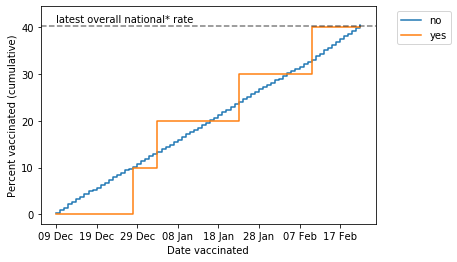

### COVID vaccinations among **80+** population by **haematological cancer**

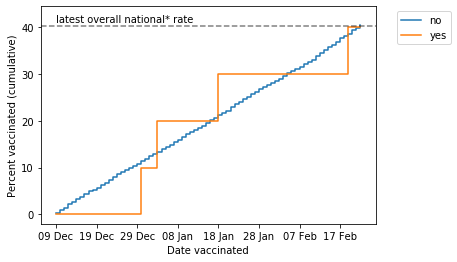

## 
 ## COVID vaccination rollout among **70-79** population up to 22 Feb 2021

### COVID vaccinations among **70-79** population by **sex**

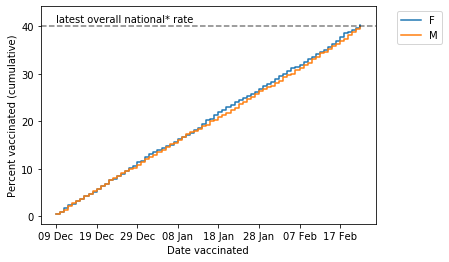

### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

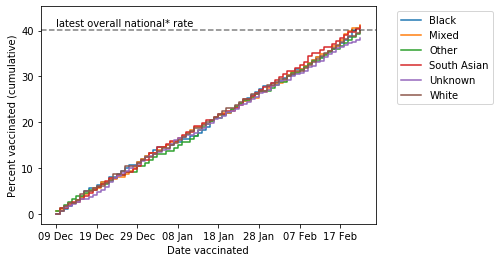

### COVID vaccinations among **70-79** population by **imd categories**

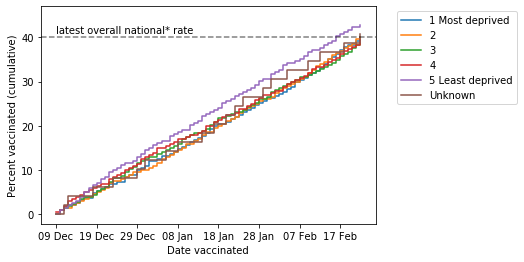

### COVID vaccinations among **70-79** population by **bmi**

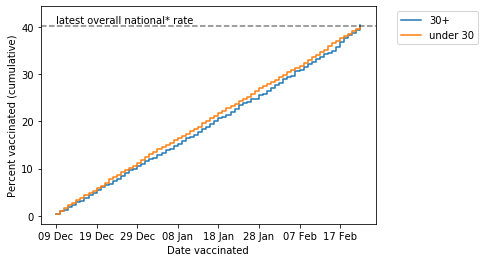

### COVID vaccinations among **70-79** population by **chronic cardiac disease**

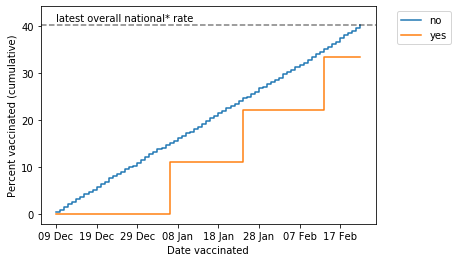

### COVID vaccinations among **70-79** population by **current copd**

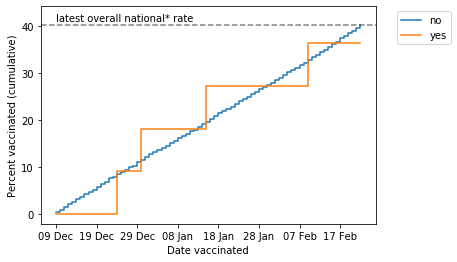

### COVID vaccinations among **70-79** population by **dialysis**

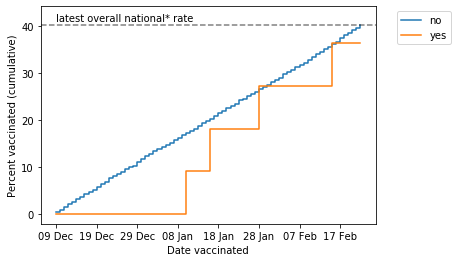

### COVID vaccinations among **70-79** population by **dmards**

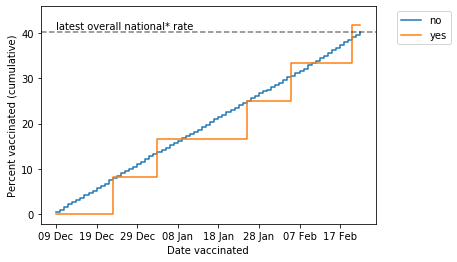

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

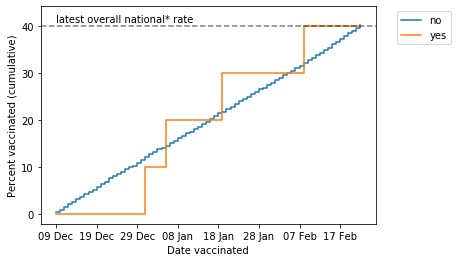

### COVID vaccinations among **70-79** population by **intel dis incl downs syndrome**

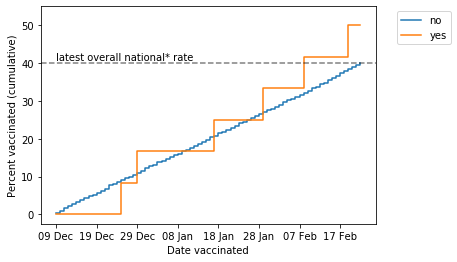

### COVID vaccinations among **70-79** population by **dementia**

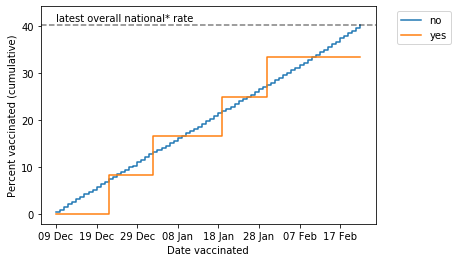

### COVID vaccinations among **70-79** population by **ssri**

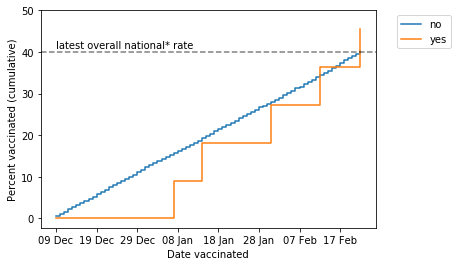

### COVID vaccinations among **70-79** population by **chemo or radio**

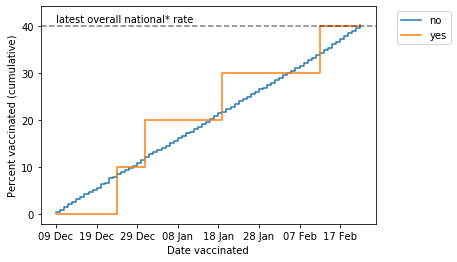

### COVID vaccinations among **70-79** population by **lung cancer**

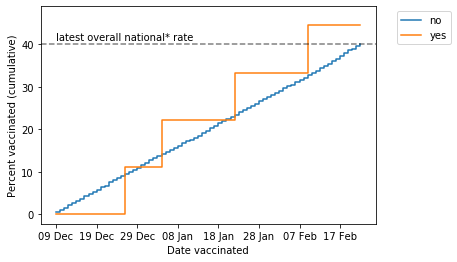

### COVID vaccinations among **70-79** population by **cancer excl lung and haem**

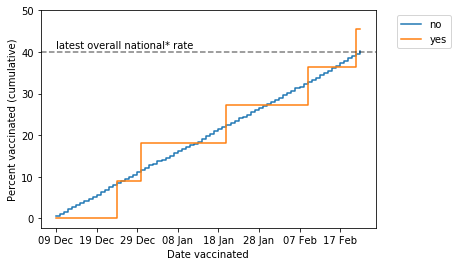

### COVID vaccinations among **70-79** population by **haematological cancer**

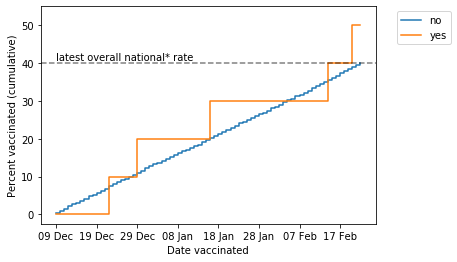

In [21]:
plot_dem_charts(summ_stat_results, df_dict_cum, formatted_latest_date, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [22]:
from data_quality import *

for g in ["80+", "70-79", "care home", "65-69", "other"]:
    ethnicity_completeness(df, group=g, 
                           name_of_other_group="under 65s, not in other eligible groups shown",
                           groups_not_in_other_group=["care home","80+", "70-79", "65-69"])

Total **80+** population with ethnicity recorded 5,092 (75.0%)

Total **70-79** population with ethnicity recorded 5,460 (74.6%)

Total **care home** population with ethnicity recorded 843 (73.8%)

Total **65-69** population with ethnicity recorded 2,343 (75.0%)

Total **under 65s, not in other eligible groups shown** population with ethnicity recorded 23,762 (75.1%)